In [92]:
import numpy as np
import pandas as pd

# Ejercicio I

   El precio de una acción es actualmente \$60 por acción y sigue un movimiento browniano geométrico:

   $
   dP_t = \mu P_t\, dt + \sigma P_t\, dW_t
   $

   Asuma que el retorno esperado $(\mu)$ es 20% anual y su volatilidad es 40% anual.

   a) Determine la distribución de probabilidad para el precio de la acción en 2 años.

   b) Obtenga la media y la desviación estándar de dicha distribución y construya un intervalo de confianza del 95% para el precio de la acción.

   c) Realice una simulación de Montecarlo y verifique si los cálculos anteriores coinciden con la simulación.


# Solucion

## Inciso a

Tenemos que :
$P_0 = 60$
$\mu$ = 0.2 anual
y $\sigma$ = 0.4 anual

Y el precio de la accion es un proceso de Ito, se puede utilizar el lema de Ito de tal manera que:


$$P_t​= P_0 e^{(\mu - \frac{\sigma^2​}{2})t+\sigma W_t}$$



Aplicando el logaritmo natural sobre la igualdad tenemos:

$$

\ln P_t 
= \ln P_0 
  + \left(\mu - \frac{\sigma^2}{2}\right)t
  + \sigma W_t.

$$


Ademas como $W_t$ es un proceso de Wiener entonces:

$$ W_t \sim \mathcal{N}(0,t) $$

Por lo tanto $$ \sigma W_t \sim \mathcal{N}(0,\sigma^2 t) $$

Ademas el termino determinista como no depende de la aletoriedad obtenemos que:

$$
\ln P_t \sim N\!\left(
\ln P_0 + \left(\mu - \frac{\sigma^2}{2}\right)t,
\; \sigma^2 t
\right).
$$ 
Por lo tanto P_t es una distribucion Lognormal:

$$
P_t \sim \mathrm{Lognormal} \!\left(
\ln P_0 + \left(\mu - \frac{\sigma^2}{2}\right)t,
\; \sigma^2 t
\right).
$$ 

donde su media es:
$ \mu = \ln P_0 + \left(\mu - \frac{\sigma^2}{2}\right)t $
y su varianza $\sigma^2 t$



Entonces evaluando en t = 2 la media $\mu$ da como resultado:

$ \mu = \ln (60) + \left(0.2 - \frac{0.4^2}{2}\right)(2) $

$\mu = \ln (60) + 0.24$ 

$\mu =  4.334344562222101$ 

In [7]:
(0.2- (0.4 **2)/2) * 2

0.24

Se define una estrucutra utilitaria para el computo de las variables

In [48]:
from dataclasses import dataclass
from typing import Optional
@dataclass
class Stats:
    ln_mean: Optional[float] = None
    ln_var: Optional[float] = None
    mean: Optional[float] = None
    var: Optional[float] = None
    std: Optional[float] = None

    def pretty_print(self):
        print("Stats:")
        print(f"  log normal mean: {self.ln_mean}")
        print(f"  log normal var:  {self.ln_var}")
        print(f"  mean:    {self.mean}")
        print(f"  var:     {self.var}")
        print(f"  std:     {self.std}")

In [39]:
mean = np.log(60) + ((0.2 - (0.4**2)/2) * 2)
print(mean)

4.334344562222101


In [40]:
var = (0.4**2)*2
print(var)

0.32000000000000006


In [49]:
info = Stats(
    ln_mean=mean,
    ln_var=var,
)

Por otro lado la varianza

$\sigma^2 t = (0.4^2)(2) = 0.32$



Entonces en t = 2 la distribucion es una lognormal:
$$
P_2 \sim \mathrm{Lognormal} \!\left(ln(60) + 0.24, 0.32\right).
$$ 

# Inciso b

Obtenga la media y la desviación estándar de dicha distribución y construya un intervalo de confianza del 95% para el precio de la acción.


Segun las propiedades de la lognormal:

$\mathbb{E}[X] = e^{\mu_\ell + \frac{\sigma_\ell^2}{2}}$


$ \mathrm{Var}[X] = (e^{\sigma_\ell^2} - 1) \, e^{2 \mu_\ell + \sigma_\ell^2} $


con

$\mu_\ell = \ln 60 + (\mu - \frac{\sigma^2}{2})t, \quad 
\sigma_\ell^2 = \sigma^2 t.$

$\mathbb{E}[P_2] = e^{\mu_\ell + \frac{\sigma_\ell^2}{2}} 
= e^{4.334 + 0.16} = e^{4.494} \approx 89.5$



$ \mathrm{Var}[P_2] =(e^{0.32} - 1) \, e^{8.988} \approx 3{,}021$

Entonces la desviacion estandar es:

$\sigma =  \sqrt{3{,}021} \approx 55$


In [52]:
info.mean = np.exp(info.ln_mean + info.ln_var/2)
print(info.mean)

89.50948185847622


In [58]:
info.var = (np.exp(info.ln_var) - 1) * np.exp(2*info.ln_mean + info.ln_var)
print(info.var)

3021.5277892819254


In [61]:
info.std = np.sqrt(info.var) 
print(info.std)

54.96842538477817


In [62]:
info.pretty_print()

Stats:
  log normal mean: 4.334344562222101
  log normal var:  0.32000000000000006
  mean:    89.50948185847622
  var:     3021.5277892819254
  std:     54.96842538477817


### Intervalo de confianza

$\ln P_2 \in \mu_\ell \pm 1.96 \, \sigma_\ell$

In [68]:
info.ln_mean + 1.96 * np.sqrt(info.ln_var)

np.float64(5.443087995122608)

In [70]:
info.ln_mean - 1.96 * np.sqrt(info.ln_var)

np.float64(3.2256011293215936)

Entonces se tiene como intervalo de confianza:


$P_2 \in [e^{3.226}, e^{5.443}] \approx [25.2, 231.15]$


# Inciso C

Realice una simulación de Montecarlo y verifique si los cálculos anteriores coinciden con la simulación.

In [81]:
def monte_carlo(P0:float, mu:float, sigma:float, time:float, N=100000, iterations=10, seed=None):

    if seed is not None:
        np.random.seed(seed)
    
    results = []
    
    for i in range(iterations):
        W_T = np.random.normal(0, np.sqrt(time), N)
        P_T = P0 * np.exp((mu - 0.5 * sigma**2)*time + sigma*W_T)
        
        mean_sim = np.mean(P_T)
        std_sim = np.std(P_T)
        conf95_sim = np.percentile(P_T, [2.5, 97.5])
        
        results.append({
            'mean': mean_sim,
            'std': std_sim,
            'conf95': conf95_sim
        })
    
    return results


iter_results = monte_carlo(P0=60, mu=0.20, sigma=0.40, time=2, N=100000, iterations=100, seed=42)

for idx, res in enumerate(iter_results, 1):
    print(f"Iteración {idx}: mu={res['mean']:.2f}, std={res['std']:.2f}, intervalo de confianza 95=[{res['conf95'][0]:.2f}, {res['conf95'][1]:.2f}]")


Iteración 1: mu=89.58, std=54.95, intervalo de confianza 95=[25.13, 231.30]
Iteración 2: mu=89.51, std=54.65, intervalo de confianza 95=[25.04, 231.64]
Iteración 3: mu=89.42, std=54.76, intervalo de confianza 95=[25.15, 230.59]
Iteración 4: mu=89.53, std=54.83, intervalo de confianza 95=[25.08, 231.65]
Iteración 5: mu=89.24, std=54.97, intervalo de confianza 95=[25.16, 230.38]
Iteración 6: mu=89.48, std=55.32, intervalo de confianza 95=[25.20, 232.52]
Iteración 7: mu=89.62, std=54.93, intervalo de confianza 95=[25.28, 230.08]
Iteración 8: mu=89.62, std=55.10, intervalo de confianza 95=[25.16, 230.46]
Iteración 9: mu=89.31, std=54.43, intervalo de confianza 95=[24.95, 231.46]
Iteración 10: mu=88.99, std=54.62, intervalo de confianza 95=[25.10, 228.95]
Iteración 11: mu=89.73, std=55.54, intervalo de confianza 95=[25.04, 233.07]
Iteración 12: mu=89.60, std=55.04, intervalo de confianza 95=[25.20, 231.31]
Iteración 13: mu=89.13, std=54.65, intervalo de confianza 95=[25.17, 229.77]
Iteració

In [78]:
info.pretty_print()

Stats:
  log normal mean: 4.334344562222101
  log normal var:  0.32000000000000006
  mean:    89.50948185847622
  var:     3021.5277892819254
  std:     54.96842538477817


La simulacion de montecarlo coincide con los calculos realizados.

# Ejercicio II

Considere un proceso estocástico discreto que sigue un modelo ARMA(5,3).

a) Genere una secuencia temporal sintética de dicho proceso de largo T = 10000.

b) Suponga que las observaciones de la señal están disponibles únicamente cada 10 instantes de tiempo.

c) Formule e implemente un filtro de Kalman que permita estimar los estados intermedios y realizar pronósticos.

d ) Evalúe el desempeño del filtro comparando las estimaciones con los valores verdaderos de la
señal simulada.

## Inciso A
Genere una secuencia temporal sintética de dicho proceso de largo T = 10000.

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess

# Parámetros del ARMA(5,3)
ar = np.array([1, -0.6, 0.25, -0.08, -0.03, 0.02])  
ma = np.array([1,  0.5, -0.4, 0.2])                 

T = 10000
np.random.seed(42)

arma = ArmaProcess(ar, ma)
series = arma.generate_sample(nsample=T)

print(series[:10])
print("Media:", series.mean())
print("Std:", series.std())

[ 0.49671415  0.40812127  0.50056495  2.23956846  1.50678424 -0.4443549
  1.40312266  2.73454606  0.4905412  -0.00383679]
Media: -0.005010217485173962
Std: 1.4867313049072608


# Inciso B

b) Suponga que las observaciones de la señal están disponibles únicamente cada 10 instantes de tiempo.

In [105]:
obs = series.copy()
mask_obs = (np.arange(T) % 10 == 0)
obs[~mask_obs] = np.nan 
y = pd.Series(obs)
mask_obs.shape

(10000,)

# Inciso C
c) Formule e implemente un filtro de Kalman que permita estimar los estados intermedios y realizar pronósticos.

En este caso se considera el error de medicion como $R_k = 0$

In [152]:
def kalman_filter_arma(y, ar, ma, W=1e-1):
    p = len(ar) - 1
    q = len(ma) - 1
    r = p + q  

    # matriz de transicion
    F = np.zeros((r, r))

    F[0, :p] = ar[1:]
    if q > 0:
        F[0, p:] = ma[1:]


    for i in range(1, p):
        F[i, i-1] = 1  

    for i in range(p, r):
        if i-p < q-1:
            F[i, i-1] = 1  

    # Matriz de medicion
    H = np.zeros((1, r))
    H[0,0] = 1
    if q > 0:
        H[0,p:] = ma[1:]


    x = np.zeros((r,1))
    P = np.eye(r)

    x_filtered = np.zeros((len(y), r))
    P_filtered = np.zeros((len(y), r, r))

    for t in range(len(y)):
        
        x_pred = F @ x
        P_pred = F @ P @ F.T + W*np.eye(r)


        if not np.isnan(y[t]):
            y_t = y[t]
            S = H @ P_pred @ H.T 
            K = P_pred @ H.T / S 
            x = x_pred + K * (y_t - H @ x_pred)
            P = (np.eye(r) - K @ H) @ P_pred
        else:
            x = x_pred
            P = P_pred

        x_filtered[t] = x.flatten()
        P_filtered[t] = P

    x_est = x_filtered[:,0]  # señal estimada
    return x_est, x_filtered, P_filtered


In [153]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [154]:
x_est, x_filt, P_filt = kalman_filter_arma(y, ar, ma)

rmse = np.sqrt(mean_squared_error(series, x_est))
mae = mean_absolute_error(series, x_est)
corr = np.corrcoef(series, x_est)[0,1]

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Correlation: {corr:.4f}")


RMSE: 6.3034
MAE: 4.4714
Correlation: 0.0170


In [155]:
x_est = x_filt[:, 0]  
x_true = series


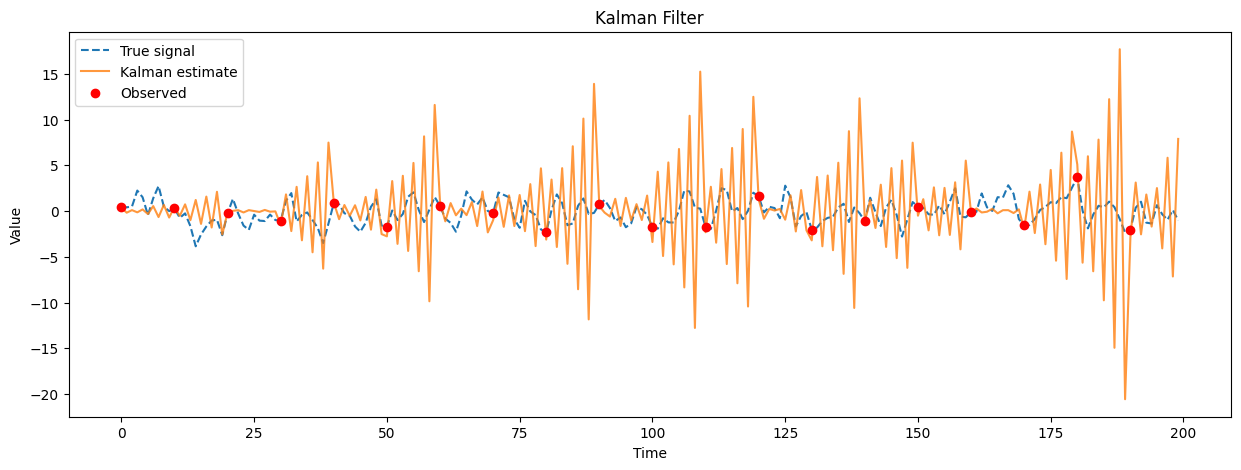

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(x_true[:200], label='True signal', linestyle='--')
plt.plot(x_est[:200], label='Kalman estimate', alpha=0.8)
plt.scatter(np.arange(T)[mask_obs][:20], y[mask_obs][:20], color='red', label='Observed', zorder=5)
plt.title('Kalman Filter')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


# Comparacion con statsmodels

In [158]:
import statsmodels.api as sm


mod = sm.tsa.SARIMAX(y, order=(5,0,3), trend='n', measurement_error=False)

res = mod.fit(disp=False)

x_est = res.filtered_state[0] 
x_est_smooth = res.smoothed_state[0]  


rmse = np.sqrt(mean_squared_error(series, x_est_smooth))
mae = mean_absolute_error(series, x_est_smooth)
corr = np.corrcoef(series, x_est_smooth)[0,1]

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Correlation: {corr:.4f}")


RMSE: 1.4128
MAE: 1.0665
Correlation: 0.3371


/home/rodz/Documents/uba/ast-II/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


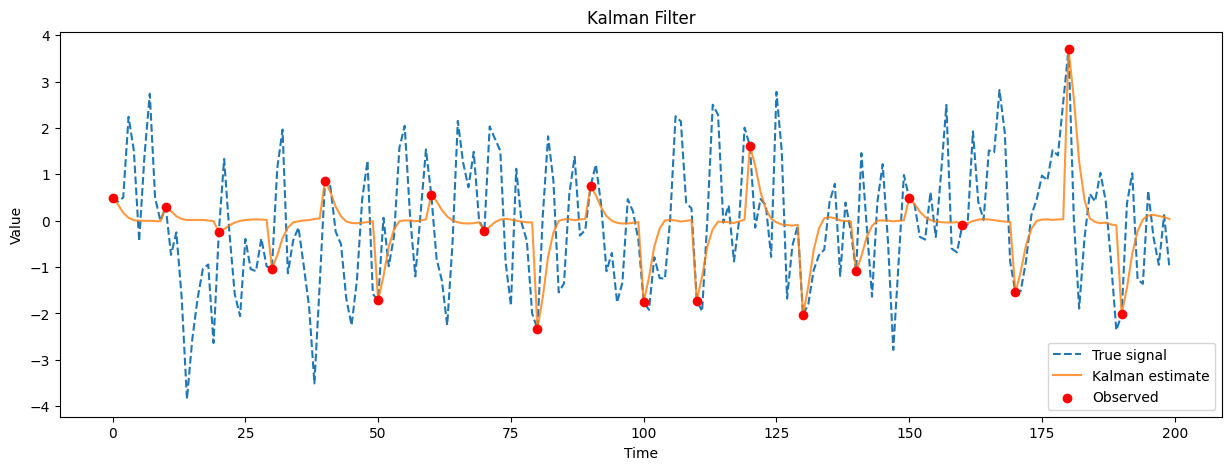

In [159]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(x_true[:200], label='True signal', linestyle='--')
plt.plot(x_est[:200], label='Kalman estimate', alpha=0.8)
plt.scatter(np.arange(T)[mask_obs][:20], y[mask_obs][:20], color='red', label='Observed', zorder=5)
plt.title('Kalman Filter')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


En este caso el filtro de kalman implementado a mano no logro asemejarse satisfactoriamente a comparacion de statsmodels sin embargo, la mayor causa de esto es que las observaciones son basicamente el 10% de la señal original, existe una alta perdida de informacion.  